In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.6319],
         [ 1.0989]]),
 tensor([[ 1.0000e+00, -1.6319e+00,  1.3315e+00, -7.2429e-01,  2.9549e-01,
          -9.6440e-02,  2.6230e-02, -6.1148e-03,  1.2473e-03, -2.2617e-04,
           3.6908e-05, -5.4753e-06,  7.4459e-07, -9.3468e-08,  1.0895e-08,
          -1.1853e-09,  1.2089e-10, -1.1605e-11,  1.0521e-12, -9.0360e-14],
         [ 1.0000e+00,  1.0989e+00,  6.0383e-01,  2.2119e-01,  6.0768e-02,
           1.3356e-02,  2.4462e-03,  3.8403e-04,  5.2754e-05,  6.4414e-06,
           7.0787e-07,  7.0718e-08,  6.4762e-09,  5.4746e-10,  4.2973e-11,
           3.1483e-12,  2.1623e-13,  1.3978e-14,  8.5339e-16,  4.9359e-17]]),
 tensor([-5.5776,  5.5502]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
# 定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.017322   1.2103064 -3.4290574  5.6039605]]


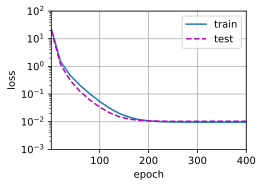

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.2028327 3.7411923]]


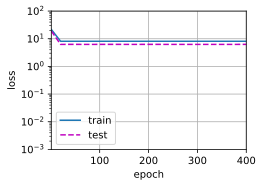

In [7]:
# 线性模型容易欠拟合
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.997708    1.3010907  -3.3658855   5.0768585  -0.13167112  1.4810051
  -0.01465437  0.19180389  0.01535411 -0.01663977  0.1380209   0.20533285
   0.21132141 -0.11193933 -0.17149098  0.04424244 -0.04364071  0.16199198
   0.20518276  0.21767637]]


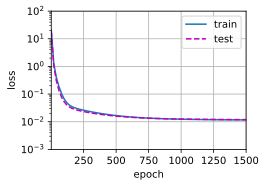

In [8]:
# 复杂模型对数据造成了过拟合
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)